<a href="https://colab.research.google.com/github/Namtk214/AIO-Homework/blob/main/Exercise_of_Multilayer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict Energy Consumption

In [2]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 32.4MB/s]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [7]:
X = dataset.drop('MPG', axis=1)
y = dataset['MPG'].values

In [8]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, shuffle=is_shuffle, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, shuffle=is_shuffle, random_state=random_state)

In [9]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
# test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [13]:
input_dims = X_train.shape[1]
hidden_dims = 64
output_dims = 1
model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [14]:
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [15]:
def r_squared(y_pred, y_true):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [16]:
import torch
from torch.utils.data import DataLoader


epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.cpu().tolist()
        train_target += y_samples.cpu().tolist()

        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_predict += outputs.cpu().tolist()
            val_target += y_samples.cpu().tolist()

            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))

    print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}")



EPOCH 1:	Training loss: 282.769	Validation loss: 88.672

EPOCH 2:	Training loss: 137.669	Validation loss: 72.346

EPOCH 3:	Training loss: 71.007	Validation loss: 19.143

EPOCH 4:	Training loss: 25.083	Validation loss: 196.176

EPOCH 5:	Training loss: 96.139	Validation loss: 20.444

EPOCH 6:	Training loss: 17.765	Validation loss: 9.444

EPOCH 7:	Training loss: 18.486	Validation loss: 14.535

EPOCH 8:	Training loss: 37.859	Validation loss: 37.427

EPOCH 9:	Training loss: 17.133	Validation loss: 38.134

EPOCH 10:	Training loss: 22.991	Validation loss: 41.183

EPOCH 11:	Training loss: 26.723	Validation loss: 20.063

EPOCH 12:	Training loss: 9.852	Validation loss: 5.594

EPOCH 13:	Training loss: 15.143	Validation loss: 16.025

EPOCH 14:	Training loss: 12.213	Validation loss: 12.023

EPOCH 15:	Training loss: 14.222	Validation loss: 7.731

EPOCH 16:	Training loss: 10.845	Validation loss: 18.904

EPOCH 17:	Training loss: 12.312	Validation loss: 14.885

EPOCH 18:	Training loss: 15.474	Validati

In [17]:
model.eval()
with torch.no_grad():
    y_hat = model(X_test.to(device))
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set :')
    print(f'R2 score: {test_set_r2}')

Evaluation on test set :
R2 score: 0.8789367079734802


Classification

In [18]:
! gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 15.3MB/s]


In [19]:
data_path = '/content/NonLinear_data.npy'
data  = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [20]:
X.shape, y.shape

((300, 2), (300,))

In [21]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, shuffle=is_shuffle, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, shuffle=is_shuffle, random_state=random_state)

In [22]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [23]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [25]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [26]:
input_dims = X_train.shape[1]
hidden_dims = 128
output_dims = torch.unique(y_train).shape[0]
model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [27]:
lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [28]:
def compute_accuracy(y_hat, y_true):
    _, y_hat =  torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [29]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    # Compute training loss and accuracy
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []

    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    # Compute validation loss and accuracy
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # Print training and validation metrics
    print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}")



EPOCH 1:	Training loss: 0.861	Validation loss: 0.854

EPOCH 2:	Training loss: 0.744	Validation loss: 0.800

EPOCH 3:	Training loss: 0.697	Validation loss: 0.788

EPOCH 4:	Training loss: 0.649	Validation loss: 0.761

EPOCH 5:	Training loss: 0.659	Validation loss: 0.737

EPOCH 6:	Training loss: 0.642	Validation loss: 0.709

EPOCH 7:	Training loss: 0.601	Validation loss: 0.717

EPOCH 8:	Training loss: 0.600	Validation loss: 0.668

EPOCH 9:	Training loss: 0.570	Validation loss: 0.651

EPOCH 10:	Training loss: 0.572	Validation loss: 0.657

EPOCH 11:	Training loss: 0.557	Validation loss: 0.613

EPOCH 12:	Training loss: 0.536	Validation loss: 0.590

EPOCH 13:	Training loss: 0.519	Validation loss: 0.570

EPOCH 14:	Training loss: 0.513	Validation loss: 0.563

EPOCH 15:	Training loss: 0.501	Validation loss: 0.546

EPOCH 16:	Training loss: 0.480	Validation loss: 0.537

EPOCH 17:	Training loss: 0.473	Validation loss: 0.513

EPOCH 18:	Training loss: 0.471	Validation loss: 0.511

EPOCH 19:	Training

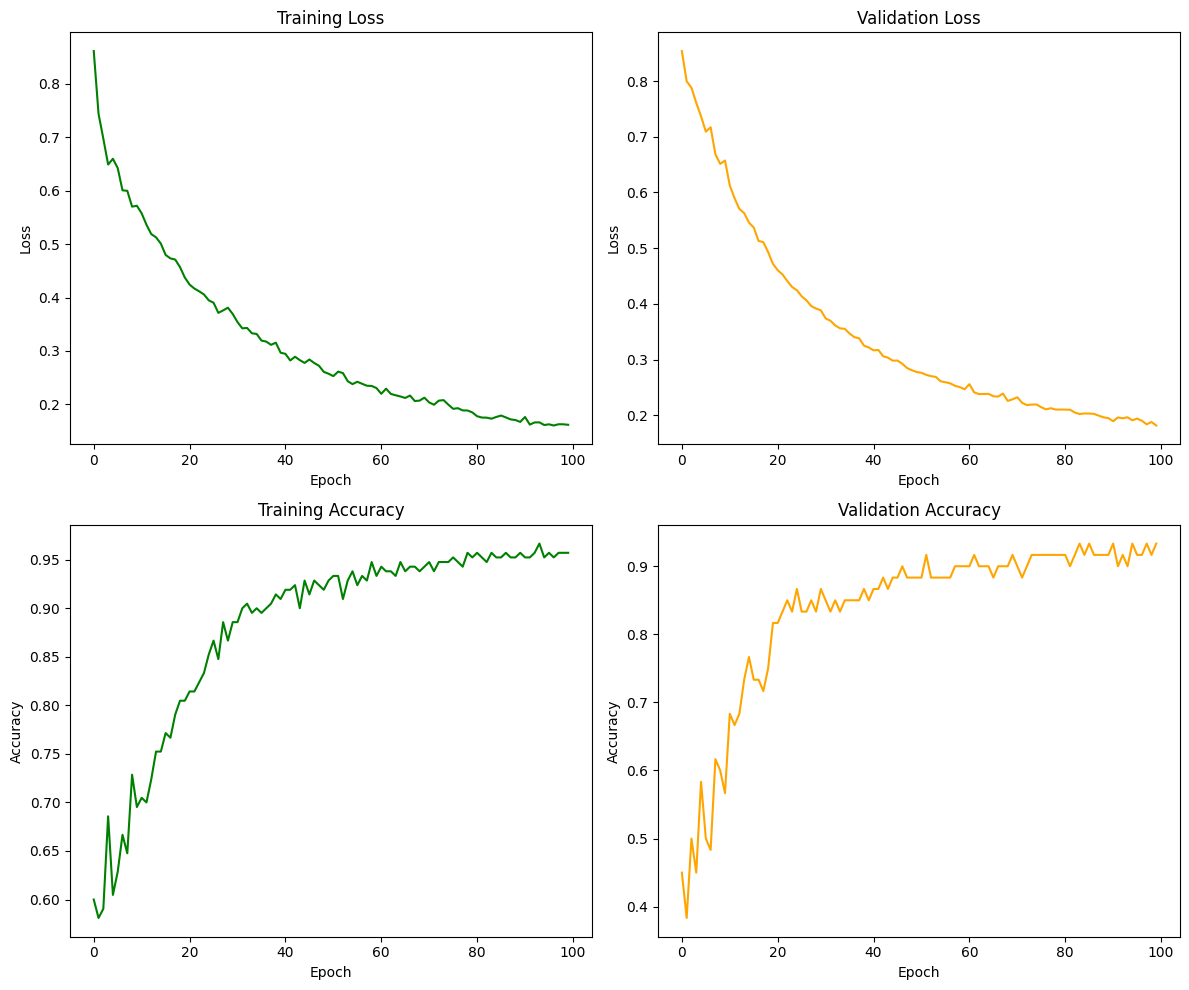

In [30]:

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot Training Loss
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Plot Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Plot Training Accuracy
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Plot Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()


In [31]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

# Assuming X_test and y_test are your test data features and labels (NumPy arrays)
# Convert them to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Now you can use test_data in your DataLoader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Looking in indexes: https://download.pytorch.org/whl/cu118


<ipython-input-31-745fefda5310>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-31-745fefda5310>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [32]:
test_target = []
test_predict = []
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

# Concatenate predictions and targets
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Compute accuracy
test_acc = compute_accuracy(test_predict, test_target)

# Display results
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.3f}')


Evaluation on test set:
Accuracy: 0.933


Sentiment Analysis

In [33]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=b4ae27cf-177b-4da9-8d5d-94ffd5bc9c7c
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 44.5MB/s]


In [34]:
!unzip -q '/content/FER-2013.zip'

In [35]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [37]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {cls:idx for cls, idx in label2idx.items()}

In [42]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)


class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.img_dir = img_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=self.train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in os.listdir(self.img_dir):
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_path = os.path.join(self.img_dir, cls, img)
                img_paths.append(img_path)
                img_labels.append(cls)
        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label


In [43]:
batch_size = 256

# Training dataset and dataloader
train_dataset = ImageDataset(
    train_dir,
    True,
    label2idx,
    split='train'
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True  # Shuffle for training
)

# Validation dataset and dataloader
val_dataset = ImageDataset(
    train_dir,
    True,
    label2idx,
    split='val'
)
val_loader = DataLoader(
    val_dataset,
    batch_size,
    shuffle=False  # No shuffling for validation
)

# Test dataset and dataloader
test_dataset = ImageDataset(
    test_dir,
    True,
    label2idx,
    split='test'
)
test_loader = DataLoader(
    test_dataset,
    batch_size,
    shuffle=False  # No shuffling for testing
)


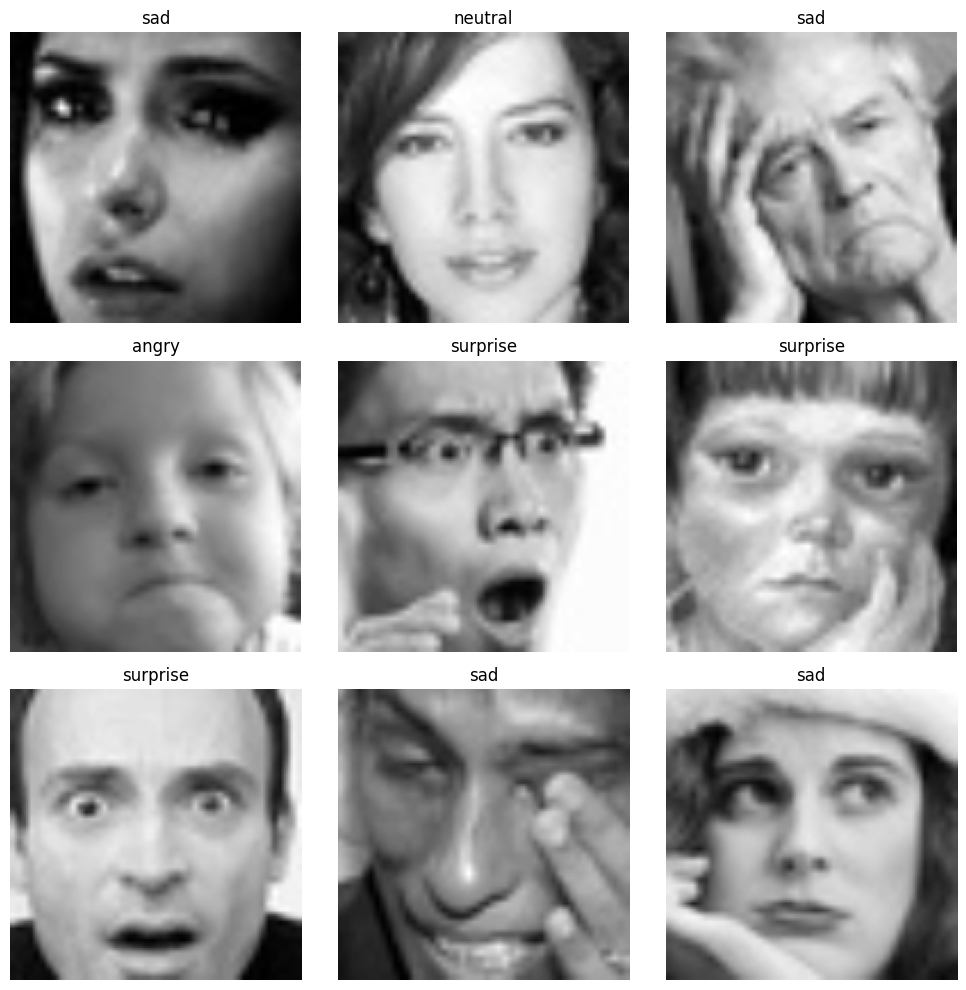

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Fetch a single batch of images and labels
image_batch, label_batch = next(iter(train_loader))

# Plot the first 9 images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # Convert the tensor to a NumPy array and normalize for display
    img = image_batch[i].permute(1, 2, 0).numpy()  # Rearrange channels to (H, W, C)
    minv, maxv = img.min(), img.max()
    img = (img - minv) / (maxv - minv)  # Normalize to [0, 1] for visualization

    plt.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)

    # Get the label and title
    label = label_batch[i].item()

    # Fix: Use label to get the class name from a reversed dictionary
    # or create a new dictionary mapping indices to class names
    plt.title(list(label2idx.keys())[list(label2idx.values()).index(label)])

    plt.axis("off")
plt.tight_layout()
plt.show()

In [47]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out

input_dims = img_height*img_width
hidden_dims = 64
output_dims = len(classes)
lr = 1e-2
model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [49]:
def compute_accuracy(y_hat, y_true):
    _, y_hat =  torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [50]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []

    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}")



EPOCH 1:	Training loss: 1.920	Validation loss: 1.887

EPOCH 2:	Training loss: 1.854	Validation loss: 1.831

EPOCH 3:	Training loss: 1.809	Validation loss: 1.800

EPOCH 4:	Training loss: 1.783	Validation loss: 1.779

EPOCH 5:	Training loss: 1.763	Validation loss: 1.760

EPOCH 6:	Training loss: 1.742	Validation loss: 1.739

EPOCH 7:	Training loss: 1.720	Validation loss: 1.718

EPOCH 8:	Training loss: 1.698	Validation loss: 1.698

EPOCH 9:	Training loss: 1.679	Validation loss: 1.681

EPOCH 10:	Training loss: 1.663	Validation loss: 1.668

EPOCH 11:	Training loss: 1.651	Validation loss: 1.656

EPOCH 12:	Training loss: 1.639	Validation loss: 1.651

EPOCH 13:	Training loss: 1.630	Validation loss: 1.639

EPOCH 14:	Training loss: 1.621	Validation loss: 1.633

EPOCH 15:	Training loss: 1.613	Validation loss: 1.626

EPOCH 16:	Training loss: 1.605	Validation loss: 1.625

EPOCH 17:	Training loss: 1.597	Validation loss: 1.618

EPOCH 18:	Training loss: 1.589	Validation loss: 1.610

EPOCH 19:	Training

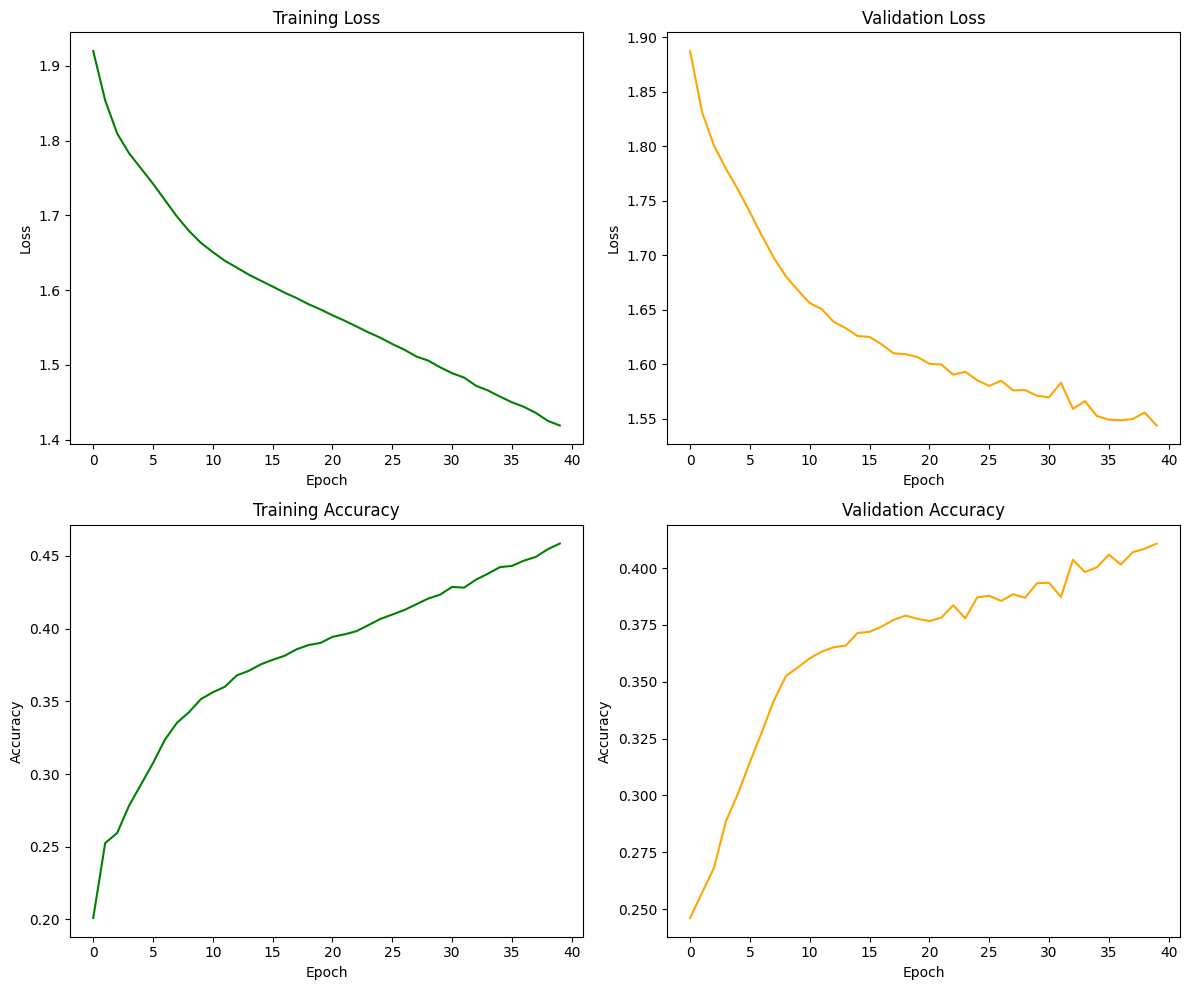

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()


In [52]:
test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

# Concatenate all batches into a single tensor
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Compute accuracy
val_acc = compute_accuracy(test_predict, test_target)

# Print results
print('Evaluation on test set:')
print(f'Accuracy: {val_acc:.3f}')


Evaluation on test set:
Accuracy: 0.409
